In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

- It's not all rosy. Global crude oil markets are navigating a complex landscape. This is largely due to geopolitical tensions and supply disruptions. There's a noticeable shift in global oil dynamics, with Brazil joining OPEC+ last year and tensions surrounding the petrodollar. 

- Vortexa data shows that... 

- In this notebook we analyse Vortexa's crude oil floating storage data (retrieved using our Python SDK) and its relationship to crude oil prices. Floating storage is directly determined by oil prices and market dynamics; however, it is not known whether floating storage may be predictive of oil prices in the future. In other words, can floating storage be used as a trading signal for crude oil? Here we apply Granger causality analysis on floating storage and price data, and for the first time demonstrate that floating storage may have significant predictive value for spot crude oil prices 2-3 months into the future.

- Fetching and Visualising Data

- Vortexa Global Crude Oil Floating Storage Data

- Continuing from our previous analysis, we will look at the 4 year period ending ono 31 January 2024. This period encapsulates the COVID pandemic, the war between Russia/Ukraine and the war between Israel and Palestine. 

In [4]:
#Defining date range for historical analysis
START_DATE = datetime(2021, 1, 31)
END_DATE = datetime(2025, 1, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

We use the CargoTimeSeries endpoint to download floating storage data from Vortexa. The function below makes an API query to retrieve the time series of global crude floating storage. The only filters set in this query are the required start and end time, the activity (set to storing_state for floating storage), and the product (set to Crude/Condensates; similar results are obtained if only Crude is selected, as Condensate floating storage volumes are low). The frequency of the time series is set to daily (the most granular available), and unit to metric tonnes (t; for barrels use b). Importantly, intra_movements is set to all so that intra-country movements are included in the aggregation. By default, this parameter includes all intra-country movements. I have specified it here for transparency. Finally, we do not set filter_storage_locations so that the query will return the total amount of crude stored globally.

In [17]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

The function above makes the API query and returns a Pandas DataFrame with the time series data. Vessels in floating storage are considered to be in cargo movements, and CargoTimeSeries() will return a count of cargo movements satisfying the filters and their total volume. When the function is run, the SDK prints some log messages confirming the parameters used in the query.

In [18]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2021-01-31,208,15424298
1,2021-02-01,206,15963901
2,2021-02-02,202,15394796
3,2021-02-03,201,15667855
4,2021-02-04,175,14271048
...,...,...,...
1457,2025-01-27,105,9663428
1458,2025-01-28,110,9664575
1459,2025-01-29,111,9823388
1460,2025-01-30,121,10254521


The returned dataframe contains the dates spanning the requested rang (2021 to 2025), the quantity in the requested unit (tonnes), and the number of cargo movements included in the aggregation. We now create a Pandas Series to hold the floating storage quantity in kilotonnes (kt) and plot this data:

Text(0, 0.5, 'Floating Storage (t)')

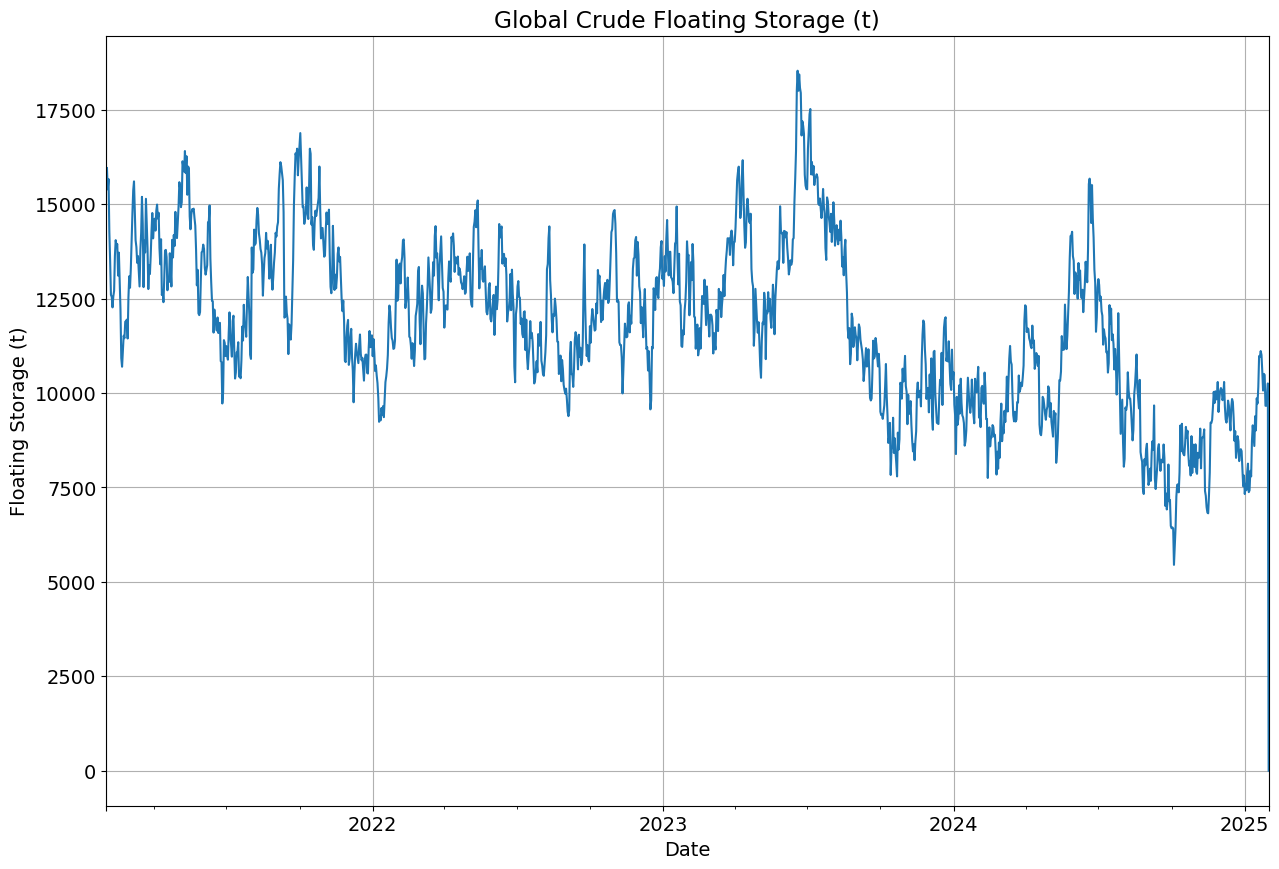

In [19]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

The graph shows that global floating storage levels remained steady between 2021 and 2023, before peaking in mid 2023 at approximately 18500t. Since then, it has seen a steady decline with a trough at approximately 5000t seen in late 2024. We will now see how the crude oil prices were behaving during this period. REFINE

EIA crude oil prices
The US Energy Information Administration (EIA) reports daily spot prices of crude oil and other products on their website. This data is publicly available and we download the Excel file directly into a Pandas DataFrame below. (NB: although the series has daily resolution, the Excel file is updated on a weekly basis. For details see the information in the Regular Weekly Releases box.) ffill is used to fill gaps in the price data, so we can compare the latest price against floating storage.

In [5]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2021-01-31,52.16,55.25
2021-02-01,53.55,56.42
2021-02-02,54.77,57.62
2021-02-03,55.67,58.61
2021-02-04,56.19,58.98
...,...,...
2025-01-27,73.51,77.30
2025-01-28,74.15,78.01
2025-01-29,72.94,77.02
2025-01-30,73.10,77.42


We open the sheet containing the crude oil spot prices (sheet Data 1) in the DataFrame and see that it contains two series: Cushing, OK WTI Spot Price and Europe Brent Spot Price. WTI (West Texas Intermediate) is the name of a crude oil grade produced in the US, and Brent is a crude grade produced in the North Sea. Both prices are used as international benchmark in oil transactions. This data is plotted below.

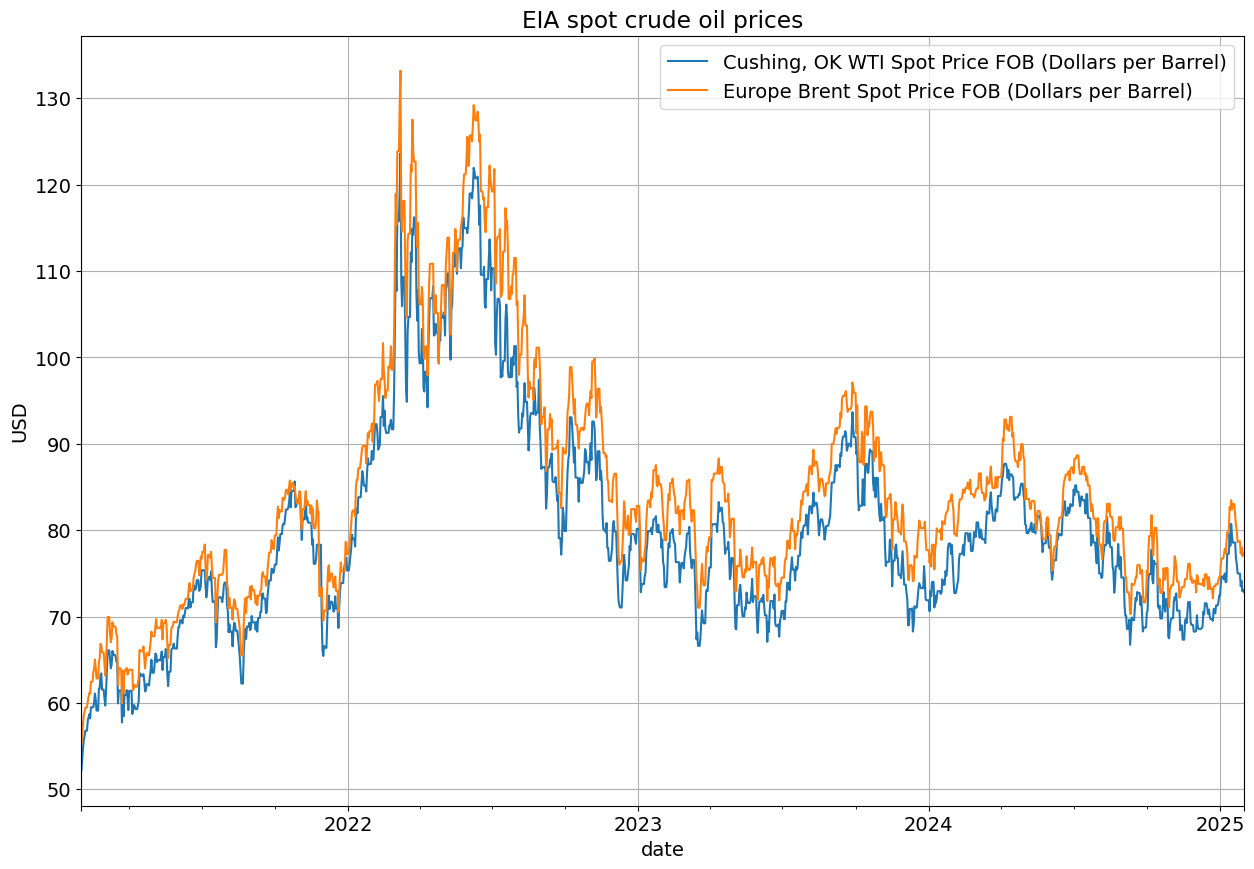

In [6]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

We can see that crude prices increased from 2021 to mid 2022, where we saw a sharp rise from roughly $70/barrel to $130/barrel. the start of 2023 saw a return to the baseline of $70-$80 per barrel. We proceed the analysis with Cushing, OK WTI Spot Price, which is kept as a Pandas Series below. We choose WTI because EIA provides both spot and future prices for WTI, but not for Brent.